# Report of AUTDMC - Phase 2

AUTDMC was an online competition to predict the number of tickets that [Alibaba.ir](www.alibaba.ir) sales in each day. 

-----------------------------

## Code

#### Importing Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations_with_replacement as combin
%matplotlib inline

In [2]:
data=pd.read_csv('data.csv')
data.drop(['Log_Time','Log_Date','AL'],axis=1,inplace=True)
data.dropna(inplace=True)

In [3]:
daymap={0:'Sat',1:'Sun',2:'Mon',3:'Tue',4:'Wed',5:'Thr',6:'Fri'}

f6=['04','12','14','18','20','24','29']
f7=['05','12','15','18','21','25','27']
f6d=[(int(x)+4)%7 for x in f6]
f7d=[(int(x))%7 for x in f7]

In [4]:
dow5=[1,4,0,3,6,2,5,0,2,4,6,1]
dow6=[3,6,2,5,1,4,0,2,4,6,1,3]
dow7=[4,0,3,6,2,5,1,3,5,0,2,4]
dow=[dow5,dow6,dow7]

# Calculating day of week
def dow_calc(s):
    arr=dow[int(s[3])-5]
    month=int(s[5:7])
    day=int(s[-2:])
    return (arr[month-1]+day-1)%7


# Padding Zeros after Groupby
def padder(res):
    for i in range(96):
        try:
            res[i]
        except:
            res[i]=0
    return res.sort_index()

# Calculating the potential passenger
def adder(inp):
    res=np.zeros(96)
    for i in range(96):
        temp=inp[i]
        for j in range(min (4,i)):
            temp+=inp[i-j-1]
        for j in range(min (3,95-i)):
            temp+=inp[i+j+1]
        res[i]=temp
    return res

#### Adding Features

In [5]:
%%time
data['Year']=data['Departure_Date'].apply(lambda x: int(x[3]))
data=data[data['Year']==6]
data['FROM']=data['FROM'].apply(int)
data['TO']=data['TO'].apply(int)
data['Departure_Time']=data['Departure_Time'].apply(int)
data['Dep_h']=data['Departure_Time'].apply(lambda x: x//100)
data['Dep_m']=data['Departure_Time'].apply(lambda x: x%100)
data['Dep']=data.apply(lambda x: x.Dep_h*4+x.Dep_m//15,axis=1)
data['Month']=data['Departure_Date'].apply(lambda x: int(x[-5:-3]))
data['Day']=data['Departure_Date'].apply(lambda x: int(x[-2:]))
data['DOW']=data['Departure_Date'].apply(dow_calc)

Wall time: 59.9 s


In [6]:
data.head(2)

,FROM,TO,Departure_Time,Departure_Date,Price,Year,Dep_h,Dep_m,Dep,Month,Day,DOW
2,3,70,2230,1396/10/09,72.2296,6,22,30,90,10,9,0
5,70,49,2000,1396/05/26,99.4400,6,20,0,80,5,26,5


### Finding Important Airports

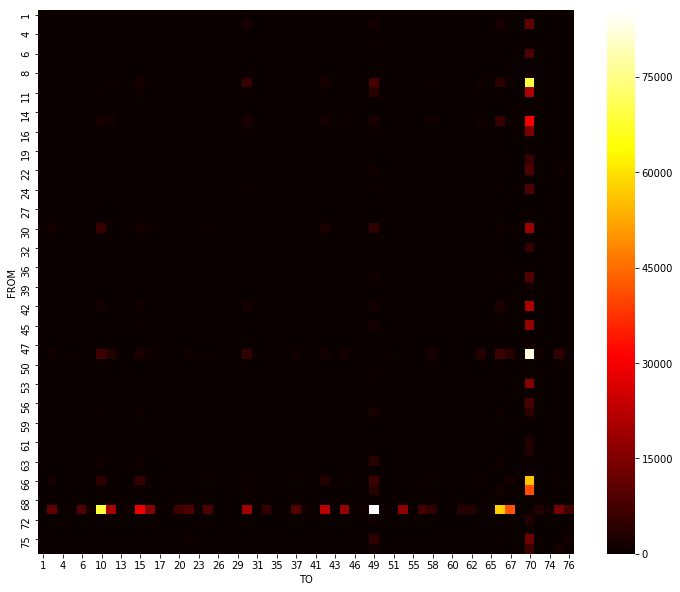

In [7]:
plt.figure(figsize=(12,10))
heat=data.groupby(['FROM','TO']).size().unstack().fillna(0)
_=sns.heatmap(heat,cmap='hot')

As the city 70 is playing an important role, we may restict ourself to the cities with the highest traffic to 70.

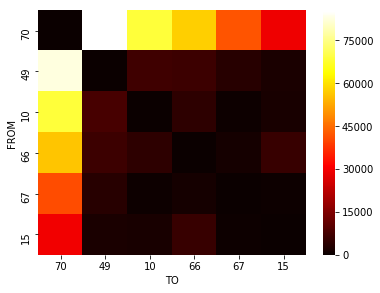

In [8]:
AP=heat[70].sort_values()[-5:].index.values
AP=np.append(AP,70)
AP=AP[::-1]
small_heat=heat[AP].loc[AP]
plt.figure(figsize=(6,4.5))
_=sns.heatmap(small_heat,cmap='hot')

Since the traffic between the cities other that 70 is negligible compared to traffic with starting/end point of 70, we just consider two-way flights to 70. Note that, you may also easily see the heatmap for the restricted data to a specific month, day, hours, etc. But there is no significant difference, we omit depicting them in the sake of brevity. The heatmap above, suggest to focus only on the cities 49,10,66.
Let us calculate the price of each period of time. As the question has said the mean value of the "Flights" (and not tickets), we just consider unique prices before getting the average. Note that the cheapest tickets are more popular and it can pull down the average if we consider the average of tickets.

### Calculation of price rate

In [9]:
%%time
AP=AP[:4]
PTALL=[]
PFALL=[]
for ap in AP[1:]:
    PT=[]
    PF=[]
    for i in range(7):
        df=data[data['Departure_Date']=='1396/06/'+f6[i]]
    
        to=[]
        frm=[]
        for t in range(0,23,6):
            temp=df[(df['FROM']==70)&(df['TO']==ap)&(df['Dep_h'].between(t,t+6))]
            to.append(np.mean(list(set(temp['Price']))))
            temp=df[(df['FROM']==ap)&(df['TO']==70)&(df['Dep_h'].between(t,t+6))]
            frm.append(np.mean(list(set(temp['Price']))))
        PT.append(np.round(to,1))
        PF.append(np.round(frm,1))
    PTALL.append(PT)
    PFALL.append(PF)

# Rates of city 10 in Shahrivar
Rate_To6=np.round(np.array(PFALL[1])/np.array(PFALL[0]),2)
Rate_From6=np.round(np.array(PFALL[1])/np.array(PFALL[0]),2)

# Rates of city 66 in Shahrivar
Rate2_To6=np.round(np.array(PFALL[2])/np.array(PFALL[0]),2)
Rate2_From6=np.round(np.array(PFALL[2])/np.array(PFALL[0]),2)

PTALL=[]
PFALL=[]
for ap in AP[1:]:
    PT=[]
    PF=[]
    for i in range(7):
        df=data[data['Departure_Date']=='1396/07/'+f7[i]]
    
        to=[]
        frm=[]
        for t in range(0,23,6):
            temp=df[(df['FROM']==70)&(df['TO']==ap)&(df['Dep_h'].between(t,t+6))]
            to.append(np.mean(list(set(temp['Price']))))
            temp=df[(df['FROM']==ap)&(df['TO']==70)&(df['Dep_h'].between(t,t+6))]
            frm.append(np.mean(list(set(temp['Price']))))
        PT.append(np.round(to,1))
        PF.append(np.round(frm,1))
    PTALL.append(PT)
    PFALL.append(PF)
    
# As we just care about the rate of the prices, normalize to have price from/to 49 =1

# Rates of city 10 in Mehr
Rate_To7=np.round(np.array(PFALL[1])/np.array(PFALL[0]),2)
Rate_From7=np.round(np.array(PFALL[1])/np.array(PFALL[0]),2)

# Rates of city 66 in Mehr
Rate2_To7=np.round(np.array(PFALL[2])/np.array(PFALL[0]),2)
Rate2_From7=np.round(np.array(PFALL[2])/np.array(PFALL[0]),2)

Wall time: 7.34 s


### Hourly traffic graphs between 70 and 49,10,66

As we had seen in the phase 1, the most important features are *Day of week* and *month*. To avoid outliers, we consider the days with the same *DOW* in *Mordad* and *Shahrivar* to have an estimation for hourly traffic graphs. We do the same with *Mehr* and *Aban* for the days in *Mehr*

#### Shahrivar

Wall time: 3.03 s


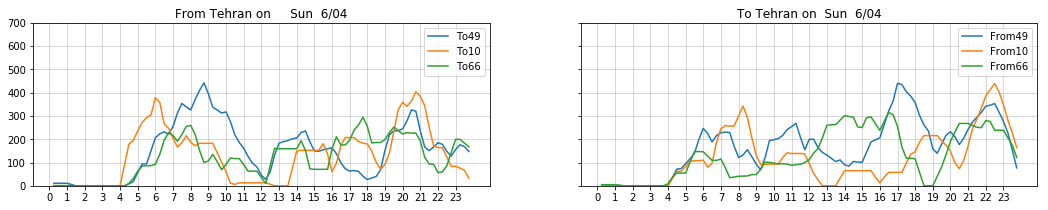

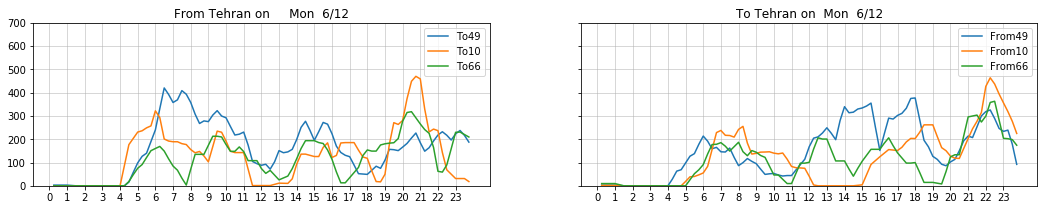

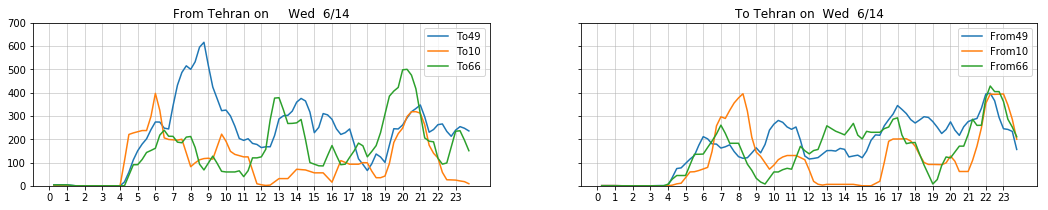

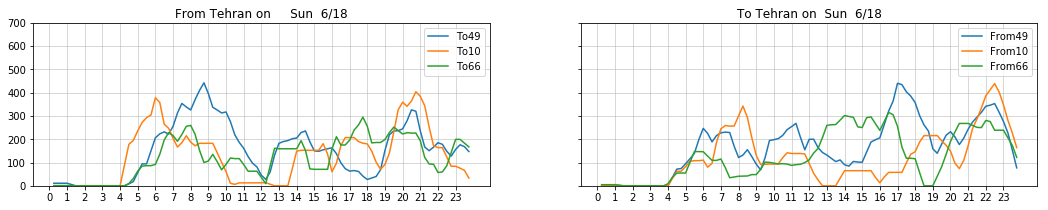

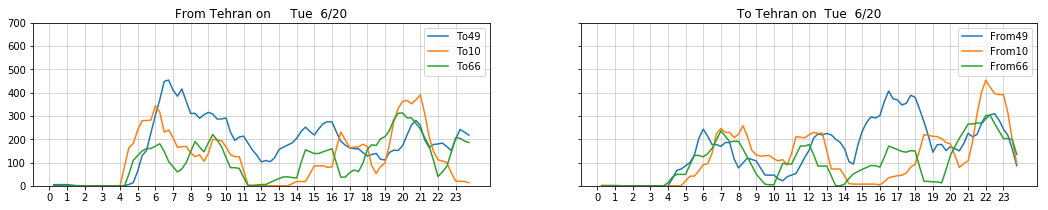

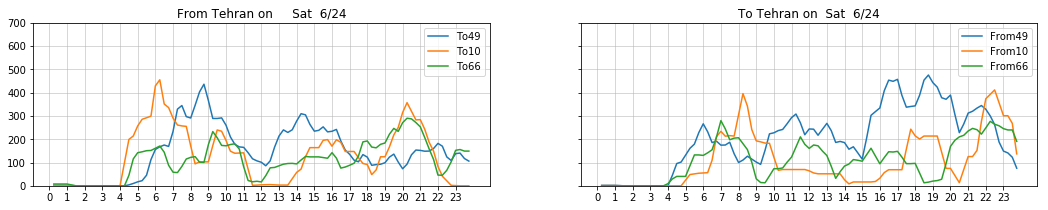

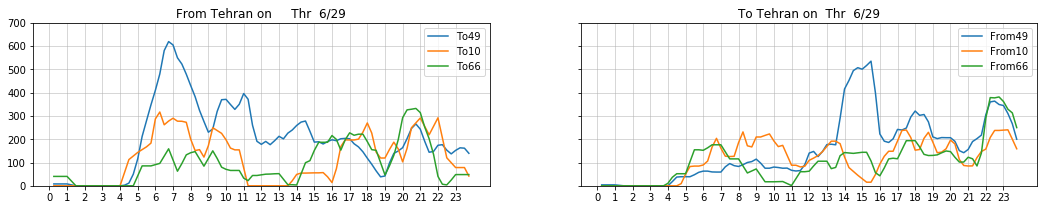

In [10]:
%%time
ylim=700
# tune rw (rolling_Window) for smoothing
rw=2
full=data[data['Month'].between(5,6)]
Sh_Graphs=[]

#Generating Graphs

for d in range(7):
    
    alldf=[]
    mydf=full[full['DOW']==f6d[d]]
    from49=mydf[(mydf['FROM']==49) & (mydf['TO']==70)]
    from10=mydf[(mydf['FROM']==10) & (mydf['TO']==70)]
    from66=mydf[(mydf['FROM']==66) & (mydf['TO']==70)]
    to10=mydf[(mydf['FROM']==70) & (mydf['TO']==10)]
    to49=mydf[(mydf['FROM']==70) & (mydf['TO']==49)]
    to66=mydf[(mydf['FROM']==70) & (mydf['TO']==66)]
    alldf.extend([to49,to10,to66,from49,from10,from66])
    
    sp=[]
    for df in alldf:
        sp.append(adder(padder(df.groupby('Dep').size())))
    Sh_Graphs.append(sp)

    
#Plotting

    fig, (ax1,ax2)= plt.subplots(1,2,sharey=True,sharex=True,figsize=(18,3))
    _=plt.xticks(range(0,96,4),range(24))
    ax1.set_title('From Tehran on     '+daymap[f6d[d]]+'  6/'+f6[d])
    graphs1=pd.DataFrame({'To49':sp[0] ,'To10':sp[1]*Rate_From6[0][np.concatenate([[i]*24 for i in range (4)])],'To66':sp[2]*Rate2_From6[0][np.concatenate([[i]*24 for i in range (4)])] })
    graphs2=pd.DataFrame({'From49':sp[3] ,'From10':sp[4]*Rate_To6[0][np.concatenate([[i]*24 for i in range (4)])],'From66':sp[5]*Rate2_To6[0][np.concatenate([[i]*24 for i in range (4)])] })
    g1=graphs1.rolling(rw).mean()
    g2=graphs2.rolling(rw).mean()
    ax1.plot(g1)
    ax2.plot(g2)  
    
    
#Styling
    
    ax1.grid(lw=0.5)
    ax2.grid(lw=0.5)
    ax1.set_ylim([0,ylim])
    ax2.set_ylim([0,ylim])
    ax2.set_title('To Tehran on  '+daymap[f6d[d]]+'  6/'+f6[d])
    ax1.legend(graphs1.columns)
    ax2.legend(graphs2.columns)
    
Sh_Graphs=np.array(Sh_Graphs)

#### Mehr

Wall time: 2.69 s


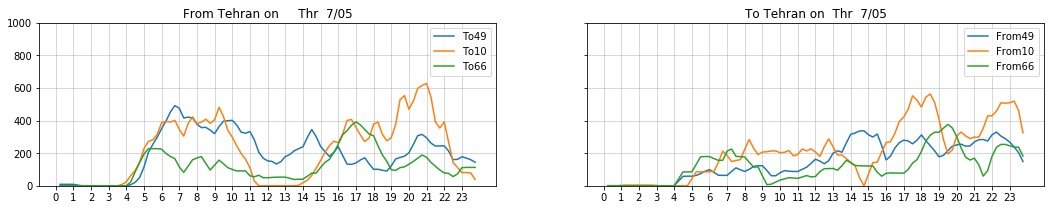

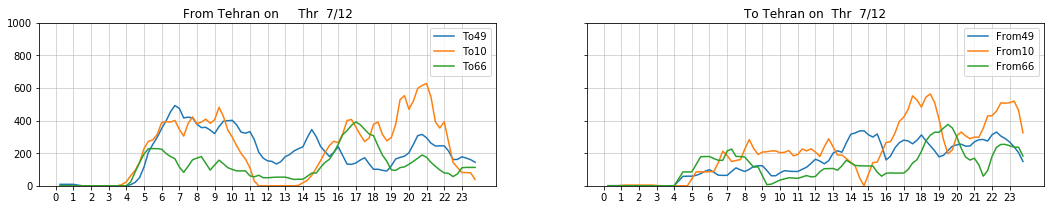

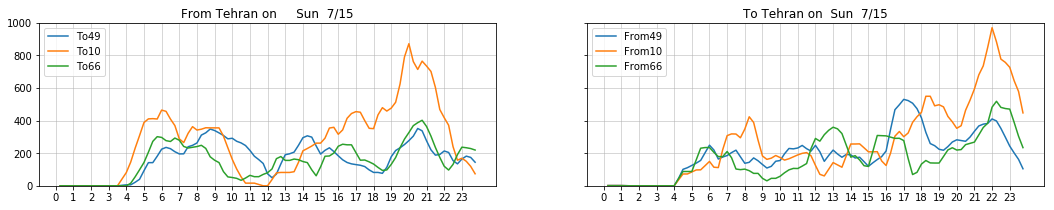

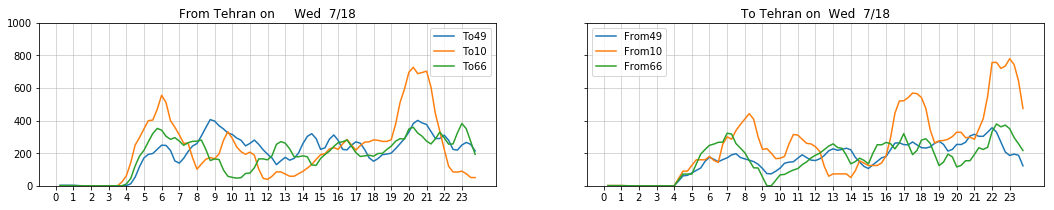

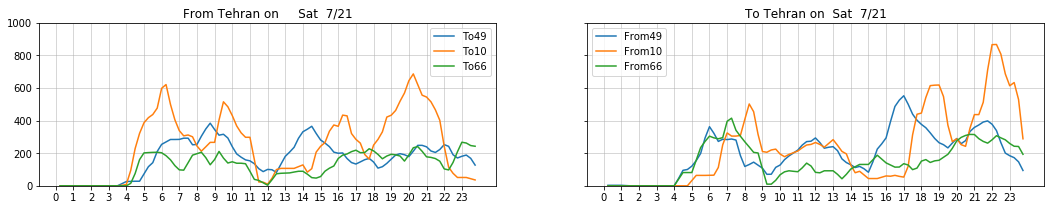

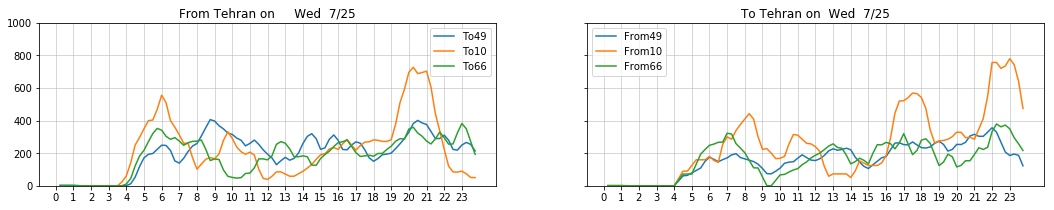

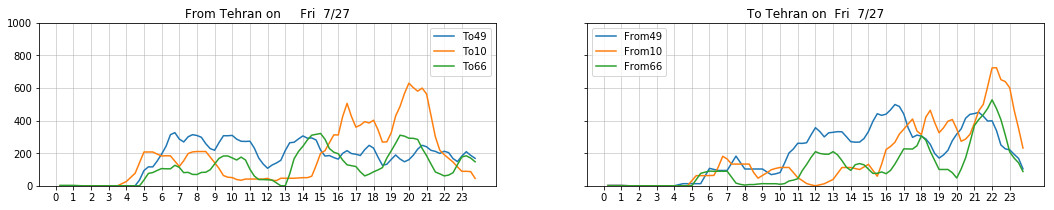

In [11]:
%%time
ylim=1000
# tune rw (rolling_Window) for smoothing
rw=2
full=data[data['Month'].between(7,8)]
M_Graphs=[]

    
#Generating Graphs

for d in range(7):
    alldf=[]
    mydf=full[full['DOW']==f7d[d]]
    from49=mydf[(mydf['FROM']==49) & (mydf['TO']==70)]
    from10=mydf[(mydf['FROM']==10) & (mydf['TO']==70)]
    from66=mydf[(mydf['FROM']==66) & (mydf['TO']==70)]
    to10=mydf[(mydf['FROM']==70) & (mydf['TO']==10)]
    to49=mydf[(mydf['FROM']==70) & (mydf['TO']==49)]
    to66=mydf[(mydf['FROM']==70) & (mydf['TO']==66)]
    alldf.extend([to49,to10,to66,from49,from10,from66])
    
    sp=[]
    for df in alldf:
        sp.append(adder(padder(df.groupby('Dep').size())))
    M_Graphs.append(sp)
    

#Plotting

    fig, (ax1,ax2)= plt.subplots(1,2,sharey=True,sharex=True,figsize=(18,3))
    _=plt.xticks(range(0,96,4),range(24))
    ax1.set_title('From Tehran on     '+daymap[f7d[d]]+'  7/'+f7[d])
    graphs1=pd.DataFrame({'To49':sp[0] ,'To10':sp[1]*Rate_From7[0][np.concatenate([[i]*24 for i in range (4)])],'To66':sp[2]*Rate2_From7[0][np.concatenate([[i]*24 for i in range (4)])] })
    graphs2=pd.DataFrame({'From49':sp[3] ,'From10':sp[4]*Rate_To7[0][np.concatenate([[i]*24 for i in range (4)])],'From66':sp[5]*Rate2_To7[0][np.concatenate([[i]*24 for i in range (4)])] })
    g1=graphs1.rolling(rw).mean()
    g2=graphs2.rolling(rw).mean()
    ax1.plot(g1)
    ax2.plot(g2)
    
    
#Styling

    ax1.grid(lw=0.5)
    ax2.grid(lw=0.5)
    ax1.set_ylim([0,ylim])
    ax2.set_ylim([0,ylim])
    ax2.set_title('To Tehran on  '+daymap[f7d[d]]+'  7/'+f7[d])
    ax1.legend(graphs1.columns)
    ax2.legend(graphs2.columns)
    
M_Graphs=np.array(M_Graphs)

### Submission

As you may notice, the green line (66) is almost always dominated by the other two. Also the orange line (10) is only feasible for late flights. As the highest picks of the *From Tehran to 49* graphs is around 8 AM and the highest picks of *To Tehran from 10* is located around 11 PM, there is a simple but generalized and effective strategy for prediction. Just starting at 2 AM and simply do a two-way trip to 49, 49, 49, and 10 every 3 hours. After a trial, it can be found out that 1:45 AM is a better option.

In [12]:
time=['1:45','4:45','7:45','10:45','13:45','16:45','19:45','22:45']
destination=[49,49,49,10]

lst=[]

for d in f6:
    for t in range(int(len(time)/2)):
        lst.append(['1397/06/'+d,time[2*t],70,destination[t]])
        lst.append(['1397/06/'+d,time[2*t+1],destination[t],70])

for d in f7:
    for t in range(int(len(time)/2)):
        lst.append(['1397/07/'+d,time[2*t],70,destination[t]])
        lst.append(['1397/07/'+d,time[2*t+1],destination[t],70])
    
sub=pd.DataFrame(lst,columns='Date,Time,From,To'.split(','))
sub.to_csv('submission.csv',index=False)

### Other Model

As mentioned before, the more simple the model is, the less likely it can be overfitted. We may design a dynamic programming algorithm to find the best combination of the flights in each day. But it is feasible to assume that it is better to do 4 two-way flight during the day. So, the gaps between the flights in very limited. So, we may just consider the solutions to the equation of

$$x_1+x_2+\ldots+x_8\leqslant11$$

where $x_i$ denote how many quarter of an hour we wait before the $i$-th flight. We may also use some recursive algorithm to produce all of solution of this equation. But for the sake of simplicity, we just use a dummy code.

In [13]:
t=12
s=[]
for i1 in range(t):
    for i2 in range(t-i1):
        for i3 in range(t-i1-i2):
            for i4 in range(t-i1-i2-i3):
                for i5 in range(t-i1-i2-i3-i4):
                    for i6 in range(t-i1-i2-i3-i4-i5):
                        for i7 in range(t-i1-i2-i3-i4-i5-i6):
                            for i8 in range(t-i1-i2-i3-i4-i5-i6-i7):
                                s.append([i1,i2,i3,i4,i5,i6,i7,i8,t-i1-i2-i3-i4-i5-i6-i7-i8-1])
delays=np.array(s)
print('Some samples of a delay vector: \n \n',delays[np.random.randint(0,len(delays),5)])

Some samples of a delay vector: 
 
 [[2 0 0 1 2 3 3 0 0]
 [2 1 0 0 3 1 0 0 4]
 [3 0 1 0 3 0 0 4 0]
 [2 0 0 1 0 7 1 0 0]
 [0 1 3 0 1 2 2 0 2]]
Wall time: 254 ms


In [14]:
def dl_to_time(dl):
    time=[]
    for i in range(8):
        time.append(i*12+sum(dl[:i+1]))
    return time

In [15]:
%%time

#Shahrivar

all_from=Sh_Graphs[:,[0,1,2],:]
all_to=Sh_Graphs[:,[3,4,5],:]
all_profits=[]
all_combins=[]
best_delay=[]
for d in range(7):
    frm=all_from[d]
    to=all_to[d]
    delay_profit=[]
    delay_combin=[]
    
    for dl in delays[:31000]:
        t=dl_to_time(dl)
        c_combins=[]
        c_profit=[]
        for c in combin([0,1,2],4):
            profit=0
            for j in range(4):
                profit+=frm[c[j]][t[2*j]]+to[c[j]][t[2*j+1]]
            c_profit.append(profit)     
            c_combins.append(c)
        max_c_profit=np.max(c_profit)
        argmax_c_profit=c_combins[np.argmax(c_profit)]
        delay_profit.append(max_c_profit)
        delay_combin.append(argmax_c_profit)
    day_max_profit=np.max(delay_profit)
    day_combin=delay_combin[np.argmax(delay_profit)]
    best_delay.append(delays[np.argmax(delay_profit)])
    all_profits.append(day_max_profit)
    all_combins.append(day_combin)
    
Sh_cmb=all_combins
Sh_dl=[dl_to_time(x) for x in best_delay]

Wall time: 6.04 s


In [16]:
%%time

#Mehr

all_from=M_Graphs[:,[0,1,2],:]
all_to=M_Graphs[:,[3,4,5],:]
all_profits=[]
all_combins=[]
all_delays=[]
best_delay=[]
for d in range(7):
    frm=all_from[d]
    to=all_to[d]
    delay_profit=[]
    delay_combin=[]
    
    for dl in delays[:31000]:
        t=dl_to_time(dl)
        c_combins=[]
        c_profit=[]
        for c in combin([0,1,2],4):
            profit=0
            for j in range(4):
                profit+=frm[c[j]][t[2*j]]+to[c[j]][t[2*j+1]]
            c_profit.append(profit)     
            c_combins.append(c)
        max_c_profit=np.max(c_profit)
        argmax_c_profit=c_combins[np.argmax(c_profit)]
        delay_profit.append(max_c_profit)
        delay_combin.append(argmax_c_profit)
    day_max_profit=np.max(delay_profit)
    day_combin=delay_combin[np.argmax(delay_profit)]
    best_delay.append(delays[np.argmax(delay_profit)])
    all_profits.append(day_max_profit)
    all_combins.append(day_combin)
    
M_cmb=all_combins
M_dl=[dl_to_time(x) for x in best_delay]

Wall time: 597 ms


In [17]:
def time_to_hour(x):
    temp=str(x//4)+':'+str(15*(x%4))
    if temp[-2:]==':0': temp+='0'
    return temp

In [18]:
lst=[]
AP=[49,10,66]
for i in range(7):
    d=f6[i]
    destination=[AP[x] for x in Sh_cmb[i]]
    time=[time_to_hour(x) for x in Sh_dl[i]]
    
    for t in range(int(len(time)/2)):
        lst.append(['1397/06/'+d,time[2*t],70,destination[t]])
        lst.append(['1397/06/'+d,time[2*t+1],destination[t],70])

for i in range(7):
    d=f7[i]
    destination=[AP[x] for x in M_cmb[i]]
    time=[time_to_hour(x) for x in M_dl[i]]
    for t in range(int(len(time)/2)):
        lst.append(['1397/07/'+d,time[2*t],70,destination[t]])
        lst.append(['1397/07/'+d,time[2*t+1],destination[t],70])
    
sub=pd.DataFrame(lst,columns='Date,Time,From,To'.split(','))
sub.to_csv('other.csv',index=False)